In [1]:
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt 

In [2]:
# Tensorflow-Keras packages
import tensorflow as tf
from tensorflow import keras
from keras import layers

In [3]:
# Define parameters values
IMG_SIZE = (256, 256)
VALID_SPLIT = 0.3
BATCH_SIZE = 32
SEED = 42
PATH = "data"

# Get train image with generator
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    PATH,
    validation_split=VALID_SPLIT,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

# Get validation image with generator
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    PATH,
    validation_split=VALID_SPLIT,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

Found 6269 files belonging to 20 classes.
Using 4389 files for training.
Found 6269 files belonging to 20 classes.
Using 1880 files for validation.


In [4]:
# Get class names
classes = train_ds.class_names

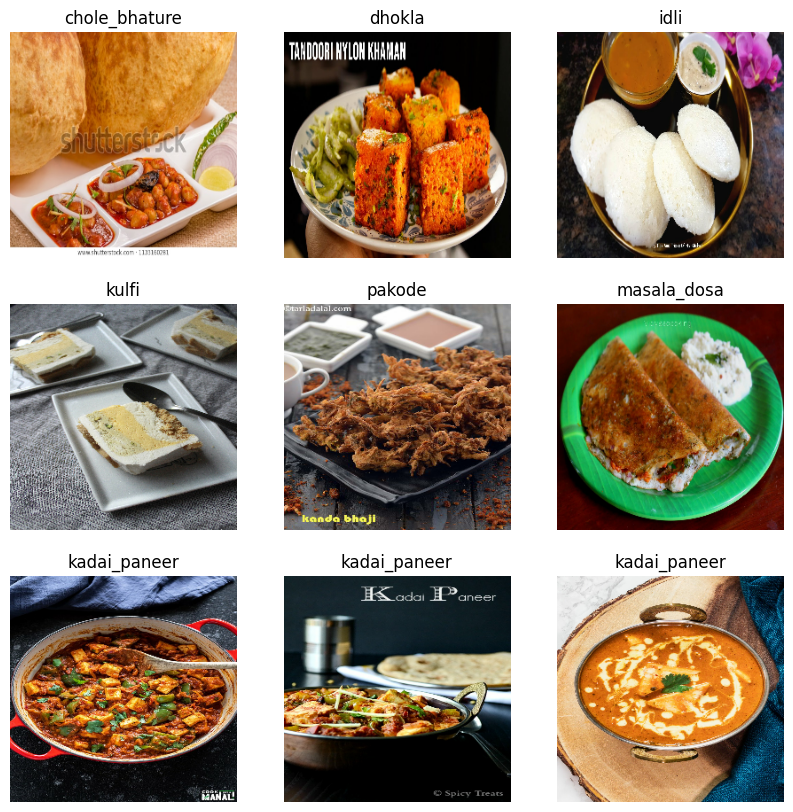

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(classes[np.argmax(labels[i])])
        plt.axis("off")

In [6]:
from tensorflow.keras import layers
from tensorflow.keras import Sequential

# Data augmentation: kind of transformations
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
])

# Apply transformation to train data
augmented_train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))


In [7]:
augmented_train_ds = augmented_train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)


In [8]:
def make_model(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)

    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)  # Updated to remove "experimental"
    x = layers.Conv2D(64, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Loop over different sizes of the network
    for size in [128, 256, 512, 512]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Final convolutional block
    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    # Global average pooling and dropout
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    
    return keras.Model(inputs, outputs)

print(IMG_SIZE + (3,))
model = make_model(input_shape=IMG_SIZE + (3,), num_classes=len(classes))

(256, 256, 3)


In [9]:
# Extend the hidden output if you want to see the model structure
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                 ┃ Output Shape             ┃        Param # ┃ Connected to              ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)   │ (None, 256, 256, 3)      │              0 │ -                         │
├──────────────────────────────┼──────────────────────────┼────────────────┼───────────────────────────┤
│ sequential (Sequential)      │ (None, 256, 256, 3)      │              0 │ input_layer_1[0][0]       │
├──────────────────────────────┼──────────────────────────┼────────────────┼───────────────────────────┤
│ rescaling (Rescaling)        │ (None, 256, 256, 3)      │              0 │ sequential[0][0]          │
├──────────────────────────────┼──────────────────────────┼────────────────┼───────────────────────────┤
│ conv2d (Conv2D)              │ (None, 128, 128, 64)     │          1,792 │ rescaling[0][0]           │
├──────────────────────────────┼──────────────────────────┼────────────────┼───────────────────────────┤
│ batch_normalization          │ (None, 128, 128, 64)     │            256 │ conv2d[0][0]              │
│ (BatchNormalization)         │                          │                │                           │
├──────────────────────────────┼──────────────────────────┼────────────────┼───────────────────────────┤
│ activation (Activation)      │ (None, 128, 128, 64)     │              0 │ batch_normalization[0][0] │
├──────────────────────────────┼──────────────────────────┼────────────────┼───────────────────────────┤
│ conv2d_1 (Conv2D)            │ (None, 128, 128, 64)     │         36,928 │ activation[0][0]          │
├──────────────────────────────┼──────────────────────────┼────────────────┼───────────────────────────┤
│ batch_normalization_1        │ (None, 128, 128, 64)     │            256 │ conv2d_1[0][0]            │
│ (BatchNormalization)         │                          │                │                           │
├──────────────────────────────┼──────────────────────────┼────────────────┼───────────────────────────┤
│ activation_1 (Activation)    │ (None, 128, 128, 64)     │              0 │ batch_normalization_1[0]… │
├──────────────────────────────┼──────────────────────────┼────────────────┼───────────────────────────┤
│ activation_2 (Activation)    │ (None, 128, 128, 64)     │              0 │ activation_1[0][0]        │
├──────────────────────────────┼──────────────────────────┼────────────────┼───────────────────────────┤
│ separable_conv2d             │ (None, 128, 128, 128)    │          8,896 │ activation_2[0][0]        │
│ (SeparableConv2D)            │                          │                │                           │
├──────────────────────────────┼──────────────────────────┼────────────────┼───────────────────────────┤
│ batch_normalization_2        │ (None, 128, 128, 128)    │            512 │ separable_conv2d[0][0]    │
│ (BatchNormalization)         │                          │                │                           │
├──────────────────────────────┼──────────────────────────┼────────────────┼───────────────────────────┤
│ activation_3 (Activation)    │ (None, 128, 128, 128)    │              0 │ batch_normalization_2[0]… │
├──────────────────────────────┼──────────────────────────┼────────────────┼───────────────────────────┤
│ separable_conv2d_1           │ (None, 128, 128, 128)    │         17,664 │ activation_3[0][0]        │
│ (SeparableConv2D)            │                          │                │                           │
├──────────────────────────────┼──────────────────────────┼────────────────┼───────────────────────────┤
│ batch_normalization_3        │ (None, 128, 128, 128)    │            512 │ separable_conv2d_1[0][0]  │
│ (BatchNormalization)         │                          │                │                           │
├─────────

 Total params: 2,105,108 (8.03 MB)

 Trainable params: 2,097,172 (8.00 MB)

 Non-trainable params: 7,936 (31.00 KB)

In [10]:
ok = False

if ok:
    
    EPOCHS = 100
    CALLBACK = [
        keras.callbacks.ModelCheckpoint("models/model.{epoch:02d}-{val_loss:.2f}.keras"),  
        keras.callbacks.EarlyStopping(patience=15)
    ]
    
    model.compile(
        optimizer='adam',
        loss="categorical_crossentropy",
        metrics=["categorical_accuracy"],
    )
    
    history = model.fit(
        augmented_train_ds,
        epochs=EPOCHS,
        callbacks=CALLBACK,
        validation_data=val_ds,
    )

    
else:
    model = keras.models.load_model('models/model.01-3.36.keras')

In [16]:
history = model.fit_generator(train_generator,
                             steps_per_epoch = nb_train_samples // batch_size,
                             validation_data = val_generator,
                             validation_steps = nb_valid_samples // batch_size,
                             epochs = 20,
                             verbose = 1,
                             callbacks = [csv_logger , checkpoints])

AttributeError: 'Functional' object has no attribute 'fit_generator'

In [14]:
# Save the model
model.save("models/model.01-3.36.keras")

In [15]:
## Accuracy and Loss Curves

def plot_accuracy(history):
    
    plt.plot(history.history['accuracy'],label='train accuracy')
    plt.plot(history.history['val_accuracy'],label='validation accuracy')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.savefig('Accuracy_v1_InceptionV3')
    plt.show()
    
def plot_loss(history):
    
    plt.plot(history.history['loss'],label="train loss")
    plt.plot(history.history['val_loss'],label="validation loss")
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.savefig('Loss_v1_InceptionV3')
    plt.show()
    
plot_accuracy(history)
plot_loss(history)
    

NameError: name 'history' is not defined